# Section 7: Differential Expression (10.23.20)
by Verena Volf (2019) and Kevin Mizes (2018), updated by Sreekar Mantena (2020)



## Part I: RNA Sequencing Analysis with edgeR

RNA-seq is the technology of choice for genome-wide differential gene expression (DGE) experiments.

The starting point for an RNA-Seq experiment is a set of $n$ RNA samples, usually associated with different treatment conditions. Each sample is sequenced and the resulting short reads are mapped to an appropriate reference genome. The number of reads mapped to each gene of interest is counted. The number of reads of a sample $i$ that are mapped to gene $g$ are denoted $y_{gi}$.

Popular software tools for RNA seq analysis include baySeq, cuffdiff, DEGSeq, DESeq, DESeq2, EBSeq, edgeR (exact and glm modes), limma, NOISeq, PoissonSeq, and SAMSeq.

Out of those, **edgeR** and DESEq 2 are the most widely used tool due to their superior TP identification rate and well-controlled FDR at lower fold changes. 

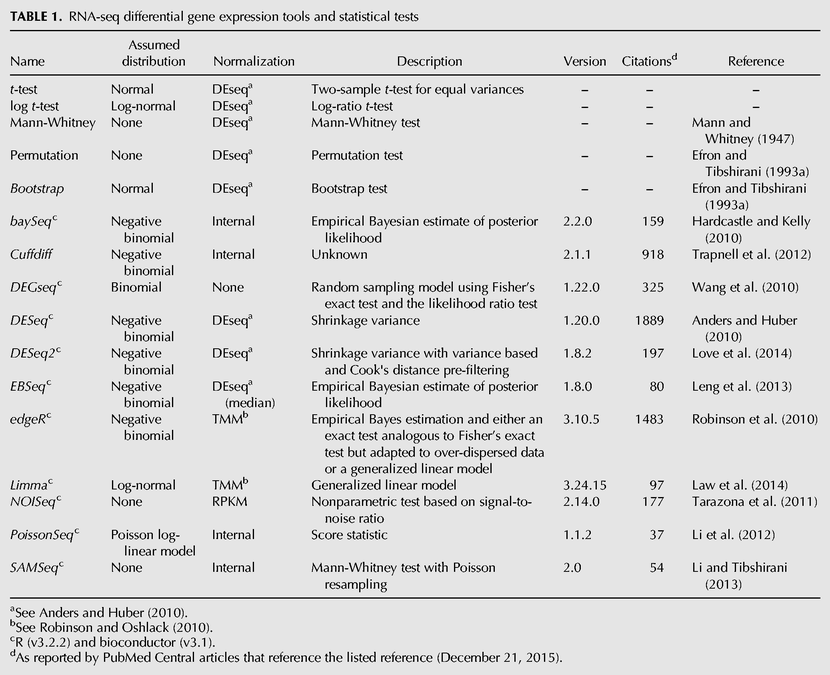

### EdgeR demonstration

In this week's class, we'll be using the software edgeR. 

This section provides a short edgeR tutorial which can be run by copying the code below into R. Running the code requires that you downloaded R, BioConductor and edgeR for which instructions are provided in the description of homework 7 (http://mcb112.org/w07/w07-homework.html). 

The code is divided into 6 sections which are described below. 

In [ ]:
# RNA-seq analysis script in R
# Note: You CANNOT run this code in Python, you'll have to run it in R.

# Importing edgeR library
library(edgeR)

### 1. Download and clean data

# download data set 
fname <- "http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE49712&format=file&file=GSE49712_HTSeq.txt.gz"
download.file(fname, destfile = "GSE49712_HTSeq.txt.gz")

data_raw <- read.table("GSE49712_HTSeq.txt.gz", header = TRUE)

#explore
# Each each row corresponds to a gene, and each column corresponds to a sample.
dim(data_raw)
head(data_raw)
tail(data_raw)
#Notice that the last five lines contain summary statistics and thus need to be removed prior to testing.
data_clean <- data_raw[1:(nrow(data_raw) - 5), ]

### 2. Remove genes with low expression

#create two groups
group <- substr(colnames(data_clean), 1, 1)
group
d <- DGEList(counts = data_clean, group = group)

dim(d) # 21711 x 10
head(cpm(d))
apply(d$counts, 2, sum) # total gene counts per sample
keep <- rowSums(cpm(d)>100) >= 2
d <- d[keep,]
dim(d) # 3605 x 10.

#reset the library sizes after filtering.
d$samples$lib.size <- colSums(d$counts)
d$samples

### 3. Normalization
d <- calcNormFactors(d)
d

### 4. Data exploration
cpm_log <- cpm(d, log = TRUE)
#heatmap(cor(cpm_log))

#MDS plot
plotMDS(d, method="bcv", col=as.numeric(d$samples$group))



### 5. estimate the dispersion

d <- estimateDisp(d)
sqrt(d$common.dispersion) # biological coefficient of variation, 0.0822604
plotBCV(d)

### 6. exact test

et <- exactTest(d)
dim(et)
results_edgeR <- topTags(et, n = nrow(data_clean), sort.by = "none")
head(results_edgeR$table)


#How many genes are differentially expressed at an FDR of less than 10%?

sum(results_edgeR$table$FDR < .1)
plotSmear(et, de.tags = rownames(results_edgeR)[results_edgeR$table$FDR < .1])
abline(h = c(-2, 2), col = "blue")

edgeR works on a table of integer read counts, with rows corresponding to genes and columns to independent libraries (RNA samples). The counts represent the total number of reads that map to each gene. 

Each function in edgeR has its own online help page. For example, a description of the exactTest function can be obtained by typing ?exactTest or help(exactTest) at the R prompt. 

#### 1. Download and clean data
We are going to use the data set generated by the Sequencing Quality Control (SEQC) project.
The data set consists of two groups of data: 

**Group A** is five technical replicates of the **Stratagene Universal Human Reference RNA**, which is a pool of ten human cell lines. 

**Group B** is five technical replicates of **Ambion's Human Brain Reference RNA**, which is RNA samples pooled from multiple donors from different brain regions. 

#### 2. Remove genes with low expression

First, we get rid of genes which are not expressed or expressed at very low levels. Here I use a cutoff of 100 counts per million and only keep genes that have a cpm of 100 or greater for at least two samples. Counts per million are calculated with the edgeR function cpm() in R. 
At this step, we create a vector called "DataGroups" which labels each of the column. We then use this vector and the gene counts to create a DGEList, the object that edgeR uses for storing data from a differential gene expression experiment. 

There are alternative ways to filter genes. Another simple method would be to choose a cutoff based on the median log2-transformed counts per gene per million mapped reads (cpm) and remove all genes with a median log2 cpm below the cutoff. 

When we take a look at the dimension of our data table (dim(d)), we see that this filtering step reduces the dataset from around 21711 genes to about 3605. For the filtered genes, there is very little power to detect differential expression, so little information is lost by filtering. 

We reset the library size (lib.size) after filtering. EdgeR will use the lib.size at later steps to calculate the effective library size by multiplying the lib.size and the norm.factors together. 

#### 3. Normalization

The calcNormFactors() function of edgeR normalizes for RNA composition by finding a set of scaling factors for the library sizes that minimize the log-fold changes between the samples for most genes. Since it is expected that only a fraction of the genes is differentially expressed, this normalization step allows for better prediction of differentially expressed genes. 

The default method for computing these scale factors with edge R uses a trimmed mean of M-values (TMM) between each pair of samples. After scaling our original library we obtain an effective library size. The effective library size replaces the original library size in all downsteam analyses.
Without this step, the default value of the edgeR norm factor is 1 for all samples. 

#### 4. Data exploration

Before we continue our DGE analysis, we generate a plot that shows the sample relations based on multidimensional scaling (MDS). MDS is a means of visualizing the level of similarity of samples. The basic premise is that we make a plot so samples which are similar are near to each other in the plot while samples that are dissimilar are far from each other. Here is an example.

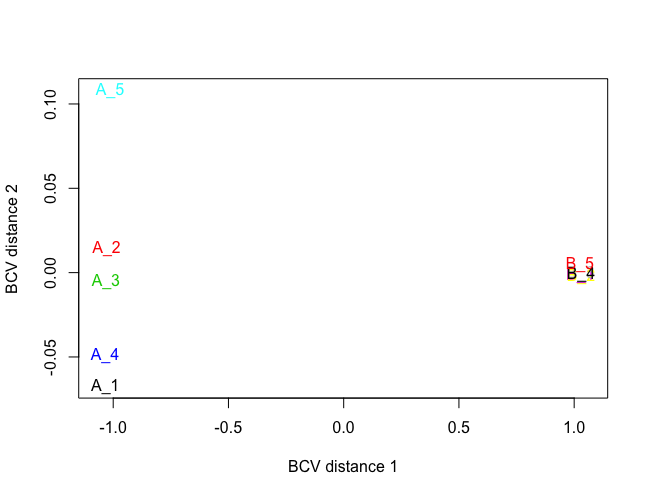


As expected, we see that samples in group A and B separate out, since they come from very different cell populations. 


#### 5. Estimating the Dispersion

The first major step in the analysis of DGE data is to estimate the dispersion parameter for each gene, a measure of the degree of inter-library variation for that tag. Estimating the common dispersion gives an idea of overall variability across the genome for this dataset. Here we assume that everything has the same common dispersion.

EdgeR refers to the dispersion estimate as the "biological coefficient of variation" (technical biases are also included in this estimate).

plotBCV() plots the per-gene tagwise biological coefficient of variation (square root of dispersions) against log2-CPM.

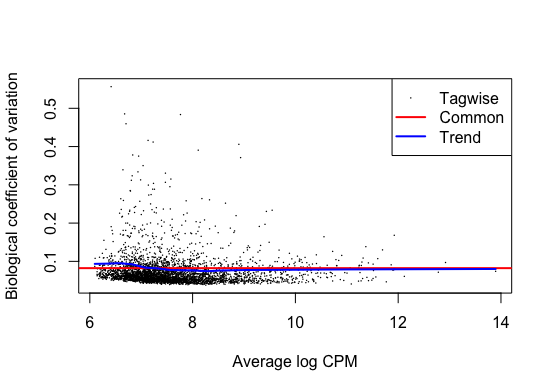

The biological coefficient of variation is lower than normally seen in human studies (~0.4) because the samples are technical replicates.

#### 6. Exact Test

After estimating the dispersion, we use the function exactTest() to evaluate whether genes are expressed differentially or not. The function tests for differential expression between two classes using a method similar in idea to the Fisher's Exact Test. The test results for the n most significant tags can be displayed with the topTags() function. Benjamini and Hochberg's algorithm is used to control the false discovery rate (FDR).


The MA plot plots the log2 fold change on the y-axis versus the average log2 counts-per-million on the x-axis. Differentially expressed genes with an FDR less than 10% are shown in red, and the blue lines represent a four-fold change in expression. 

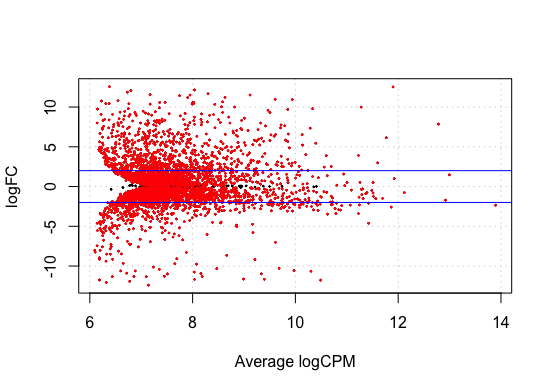

As we would expect from prior knowledge about our samples and from the Multidimensional scaling results, a large fraction of the genes are differentially expressed between the two groups. 

#### References:

Schurch, N. J., Schofield, P., Gierliński, M., Cole, C., Sherstnev, A., Singh, V., … Barton, G. J. (2016). How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use? RNA, 22(6), 839–851. https://doi.org/10.1261/rna.053959.115 (table)

https://gist.github.com/jdblischak/11384914 (edgeR intro)

https://web.stanford.edu/class/bios221/labs/rnaseq/lab_4_rnaseq.html (edgeR intro)

## Part B: Multiple Hypothesis Testing and Controlling the FDR


### What is the FDR?

As Sean has gone through in his lectures, we need some way to account for errors in our tests. With the **false discovery rate (FDR)**, we can take into account the fact that a certain number of our tests will be incorrectly discovered. By definition, the FDR is defined as the proportion of false discoveries among the total number of discoveries, where a discovery is a test that has rejected the null hypothesis.

As an example, let's say we collect the data below:

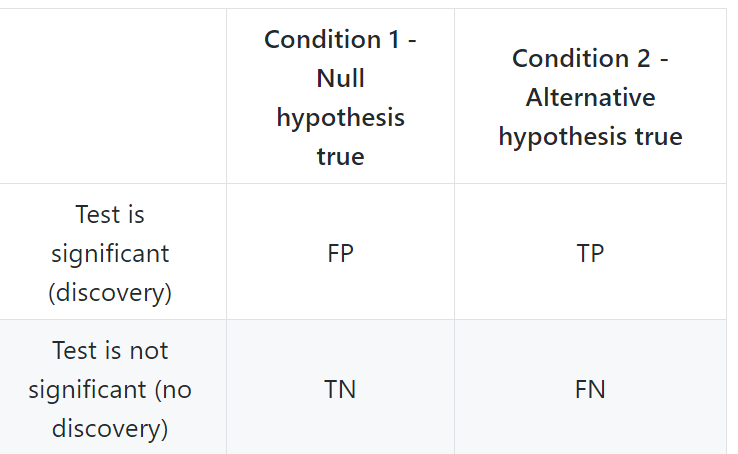


Which then tells us $\mathrm{FDR} = \frac{\mathrm{FP}}{\mathrm{FP}+\mathrm{TP}}$

Let's say we have some heart rate data, and want to detect if someone has Atrial fibrillation (Afib). Let's say our test is 95% accurate, but lifetime risk of Afib is ~25%. We test have data from 1000 heartbeats and our table looks something like:

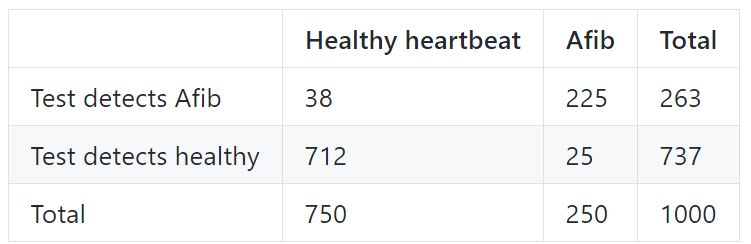

The FDR is 38/263 ~= 0.144

This means that ~14% of our discoveries are actually false positives, which is quite significant.


#### Benjamini-Hochberg FDR controlling procedure

In 1995, work began on using the FDR as a more useful metric for significance. The Benjamini-Hochberg procedure enables us to control our false discovery rate by using the following method:

Put the individual P values in order, from smallest to largest. The smallest P value has a rank of i=1, then next smallest has i=2, etc. Compare each individual P value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest P value that has P<(i/m)Q is significant, and all of the P values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value.

At the end of this process, we will have a subset of p-values from the original dataset that we identified as significant. In our RNAseq data, we'd consider these genes differentially expressed. More intuition on the Benjamini-Hochberg method is provided in this week's handwritten section notes and lecture notes.

Below, we'll use the FDR values that edgeR computed and the Benjamini-Hochberg to identify differentially expressed genes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Calculate (Benjamini-Hochberg) FDR in edgeR

In [2]:
# use Rscript to run Wiggins' R script using mydata.tbl file in hw7
!Rscript analyze_W.r

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


Seems like that worked!  Let's take a look at the results.

In [3]:
# load results in dataframe and display
data=pd.read_table('myresult.out',sep='\s+')
data.head(10)

,logFC,logCPM,PValue,FDR
currant,7.290154,11.591685,6.729741e-32,1.048977e-27
peach,7.258115,11.552154,1.047354e-31,1.048977e-27
watercress,7.219327,9.808248,2.301531e-31,1.536732e-27
apricot,7.060319,11.080741,1.208997e-30,6.054356e-27
mushroom,6.910682,11.234784,1.201314e-29,4.083102e-26
raisin,6.916321,10.369490,1.223035e-29,4.083102e-26
asparagus,6.812408,10.341082,3.331540e-29,9.044459e-26
cherry,6.833151,10.435384,3.612185e-29,9.044459e-26
grape,6.788640,11.986578,6.912830e-29,1.538566e-25
gooseberry,6.732800,11.267105,8.949742e-29,1.792723e-25


As a sanity check, let's see what the expected FDR would be if we arbitrarily set the p-value for gene `tomato` as a threshold, and compare it to the FDR value for `tomato` in the edgeR results file.

In [4]:
# store p-values in array, length of array
pvals = data['PValue'].values
n = len(pvals)
# set p-value threshold to the p-value of tomato
pr = data.loc['tomato'].PValue
FDR_edgeR = data.loc['tomato'].FDR
# calculate how many p-values are below the threshold
r = np.where(pvals < pr)
r = len(r[0])
# calculate FDR
FDR = n*data.loc['tomato'].PValue / r
print('Expected FDR for p-value threshold of {0:.3f}: {1:.3f}'.format(pr, FDR))
print('Compare to edgeR result: {0:.3f}'.format(FDR_edgeR))

Expected FDR for p-value threshold of 0.003: 0.197
Compare to edgeR result: 0.194


We get an expected FDR of 19.7% if we set the p-value threshold to 0.003, which is very close to what edgeR produced.  

Let's take a look at how many p-values would be considered significant by the Benjamini-Hochberg cutoff, keeping the expected FDR at 5%.  In order to do this, we first calculate the number of positive tests ($r$) if we set the significance cutoff at each p-value, and then plot the BH significance cutoff.

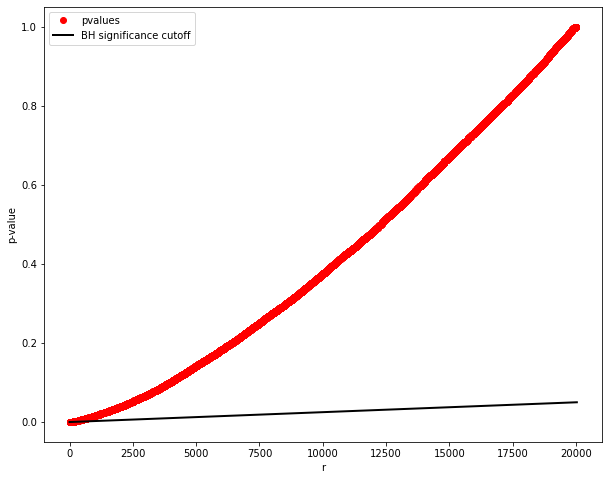

In [5]:
# calculate r (number of positive tests) if we set the cutoff at each p-value
pvals = data['PValue'].values
rvals = []
for pr in pvals:
    r = np.where(pvals < pr)
    rvals.append(len(r[0]))
    
# plot P_r vs r
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(rvals,pvals, 'ro',label='pvalues');
ax.set_ylabel('p-value');
ax.set_xlabel('r');

# plot fit line for our FDR cutoff
alpha = 0.05
n = len(pvals)
x2 = n
y2 = alpha
ax.plot([0, x2], [0, y2], color='k', linestyle='-', linewidth=2,label='BH significance cutoff');
ax.legend();
plt.show();

In the above graph, genes below the black BH significance cutoff line are considered to be differentially expressed, while those above are considered to be non-differentially expressed.

Let's zoom in to the bottom left of this plot:

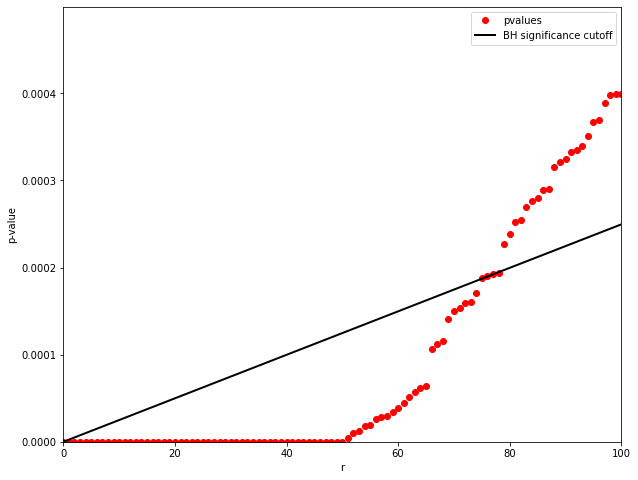

In [6]:
# calculate r (number of positive tests) if we set the cutoff at each p-value
pvals = data['PValue'].values
rvals = []
for pr in pvals:
    r = np.where(pvals < pr)
    rvals.append(len(r[0]))
    
# plot P_r vs r
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(rvals,pvals, 'ro',label='pvalues');
ax.set_ylabel('p-value');
ax.set_xlabel('r');

# plot fit line for our FDR cutoff
alpha = 0.05
n = len(pvals)
x2 = n
y2 = alpha
ax.plot([0, x2], [0, y2], color='k', linestyle='-', linewidth=2,label='BH significance cutoff');
ax.legend();
plt.xlim(0, 100)
plt.ylim(0, 2*alpha*100/n)
plt.show();

We see that very few genes are considered significant (about 80, certainly much fewer than 1905), and that the FDR cutoff is much stricter than a simple $p<0.05$.

The Benjamini-Hochberg procedure enables us to control the FDR such that we can be more certain that most of our "discoveries" are indeed true positives.

# Part C: Basic R Commands (Optional)

In this week's HW, you'll have to create a simple R script to run the edgeR analysis.

R is a programming language developed for statisticians by statisticians, and is increasingly being used for bioinformatics analysis. You will NOT have to know detailed R syntax to complete this week's HW, as you'll be putting together a short script that runs edgeR with just a few lines of R code.

However, if you are interested in learning more about R's syntax, you can review the examples below.


In [ ]:
# Basic Data Structures:

# Create an empty vector
X <- vector()

# Add elements to a vector
X <- c(1,2,3)

# Print out first element of a vector
> print (X[1])
[1] 1


# Working with R Dataframes
mtcars 
               mpg cyl disp  hp drat   wt ... 
Mazda RX4     21.0   6  160 110 3.90 2.62 ... 
Mazda RX4 Wag 21.0   6  160 110 3.90 2.88 ... 
Datsun 710    22.8   4  108  93 3.85 2.32 ... 

# Retrieve value from first row, second column
# NOTE that R is 1-indexed unlike python
mtcars[1, 2] 
# Output: [1] 6

# We can use the row and column names instead of the numeric coordinates.

mtcars["Mazda RX4", "cyl"] 
# Output: [1] 6

nrow(mtcars)    # number of data rows 
# Output: [1] 32


# And the number of columns of a data frame is given by the ncol function.

ncol(mtcars)    # number of columns 
# Output: [1] 11

# To access a particular column:

mtcars$mpg
# Output: [1] [21.0, 21.0, 22.8]